## Safe to eat or a deadly poison?

#### ***This dataset includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family Mushroom drawn from The Audubon Society Field Guide to North American Mushrooms (1981). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be'' for Poisonous Oak and Ivy.***

#### Problem : Which features are most indicative of a poisonous mushroom?

- Dataset : https://www.kaggle.com/uciml/mushroom-classification

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from collections import Counter
import itertools

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [2]:
df = pd.read_csv(r"mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [3]:
df.describe().T

,count,unique,top,freq
class,8124,2,e,4208
cap-shape,8124,6,x,3656
cap-surface,8124,4,y,3244
cap-color,8124,10,n,2284
bruises,8124,2,f,4748
odor,8124,9,n,3528
gill-attachment,8124,2,f,7914
gill-spacing,8124,2,c,6812
gill-size,8124,2,b,5612
gill-color,8124,12,b,1728


### Cramer's V :

- Cramér's V (sometimes referred to as Cramér's phi and denoted as φc) is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). 
- It is based on Pearson's chi-squared statistic 

- Cramér's V may also be applied to goodness of fit chi-squared models when there is a 1 × k table (in this case r = 1). In this case k is taken as the number of optional outcomes and it functions as a measure of tendency towards a single outcome.

- Cramér's V varies from 0 (corresponding to no association between the variables) to 1 (complete association) and can reach 1 only when the two variables are equal to each other.
- Reference : https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

In [4]:
def cramers_v(confusion_matrix):
    """ 
    Calculate Cramers V statistic for categorial-categorial association.
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(df["class"], df["odor"]).values
cramers_v(confusion_matrix) # Class is highly associated to odor (Both categorical)

0.9705579576413808

In [5]:
confusion_matrix = pd.crosstab(df["class"], df["cap-surface"]).values
cramers_v(confusion_matrix) # Class is highly correlated to odor (Both categorical) # Less associated

0.1959966392115783

In [6]:
cols = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'population', 'habitat']

In [7]:
def find_association(method,data,columns):
    
    df = data
    cols = columns
    corrM = np.zeros((len(cols),len(cols)))
    np.fill_diagonal(corrM, 1)
    
    if method == "thiels_u":
        for col1, col2 in itertools.combinations(cols, 2):
            idx1, idx2 = cols.index(col1), cols.index(col2)
            corrM[idx1, idx2] = theils_u(df[col1], df[col2])
            corrM[idx2, idx1] = corrM[idx1, idx2]
        
    elif method == "cramers_v":
        
        for col1, col2 in itertools.combinations(cols, 2):
            idx1, idx2 = cols.index(col1), cols.index(col2)
            corrM[idx1, idx2] = cramers_v((pd.crosstab(df[col1], df[col2])).values)
            corrM[idx2, idx1] = corrM[idx1, idx2]

    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    fig, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, annot=True, ax=ax); 
    ax.set_title("Correlation between Variables");

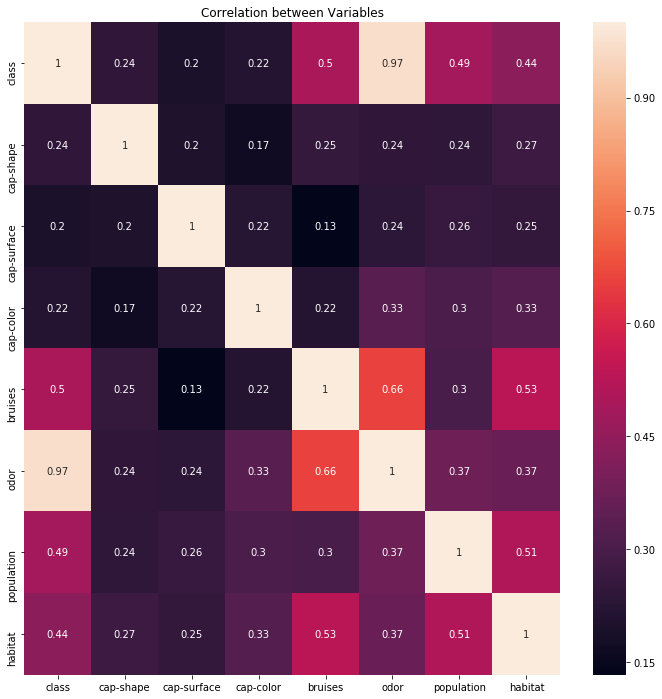

In [8]:
find_association("cramers_v",df,cols)

### Observations:

- Odor is highly associated with the class (edible/poisonous)
- Gill-attachment feature is highly associated with three others.

### Cons:

- If the value of x is known, the value of y still can’t be determined, but if the value of y is known — then the value of x is guaranteed. 
- This valuable information is lost when using Cramer’s V due to its symmetry, so to preserve it we need an asymmetric measure of association between categorical features. 

### Theil’s U:

- Referred to as the Uncertainty Coefficient, is based on the conditional entropy between x and y — given the value of x, how many possible states does y have, and how often do they occur. 
- Just like Cramer’s V, the output value is on the range of [0,1], with the same interpretations as before — but unlike Cramer’s V, it is asymmetric, meaning U(x,y)≠U(y,x) (while V(x,y)=V(y,x), where V is Cramer’s V).
- Uncertainity Coefficient : https://en.wikipedia.org/wiki/Uncertainty_coefficient
- Cross-Entropy : https://en.wikipedia.org/wiki/Cross_entropy

In [9]:
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    """
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

In [10]:
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

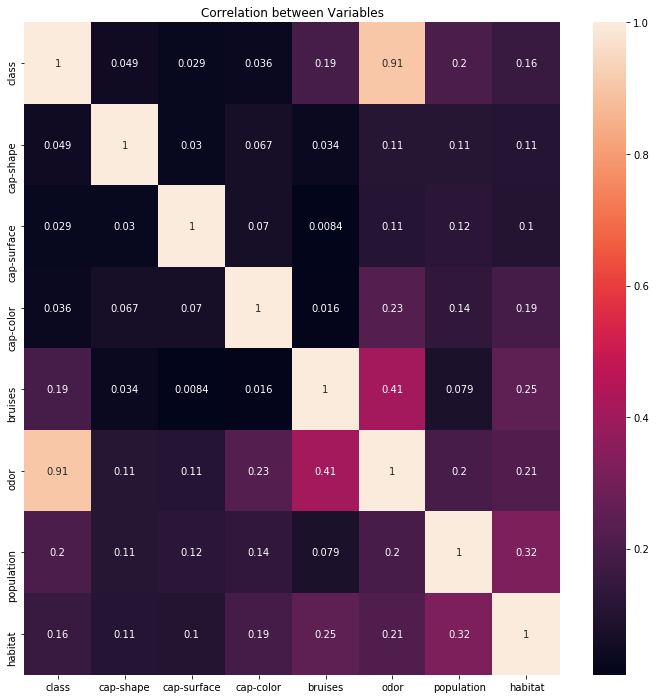

In [11]:
find_association("thiels_u",df,cols)

#### Courtesy : Information as studied and gathered from articles in reputed blogs, kaggle, wikipedia. Some functions are modified as per the need to provide correct information. Functionalization of code has been done in accordance with DRY principle.